<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 8.3: Stacking

INSTRUCTIONS:

- Read the guides and hints then create the necessary analysis and code to find an answer and conclusion for the scenario below.
- The baseline results (minimum) are:
    - **Accuracy** = 0.9667
    - **ROC AUC**  = 0.9614
- Try to achieve better results!

## Scenario: Predicting Breast Cancer
The dataset you are going to be using for this laboratory is popularly known as the **Wisconsin Breast Cancer** dataset. The task related to it is Classification.

The dataset contains a total number of _10_ features labelled in either **benign** or **malignant** classes. The features have _699_ instances out of which _16_ feature values are missing. The dataset only contains numeric values.

# Step 2: Find the Data
### Wisconsin Breast Cancer DataSet
- **Citation Request**

    This breast cancer databases was obtained from the **University of Wisconsin Hospitals**, **Madison** from **Dr. William H. Wolberg**. If you publish results when using this database, then please include this information in your acknowledgements.

- **Title**

    Wisconsin Breast Cancer Database (January 8, 1991)

- **Sources**
    - **Creator**
            Dr. William H. Wolberg (physician)
            University of Wisconsin Hospitals
            Madison, Wisconsin
            USA
    - **Donor**
            Olvi Mangasarian (mangasarian@cs.wisc.edu)
            Received by David W. Aha (aha@cs.jhu.edu)
    - **Date**
            15 July 1992
        
### UCI - Machine Learning Repository
- Center for Machine Learning and Intelligent Systems

The [**UCI Machine Learning Repository**](http://archive.ics.uci.edu/ml/about.html) is a collection of databases, domain theories, and data generators that are used by the machine learning community for the empirical analysis of machine learning algorithms.

In [1]:
# Import libraries

import re

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier as StackingClassifier_sk_learn
from mlxtend.classifier import StackingClassifier
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('breast_cancer_wisconsin_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [3]:
df.shape

(569, 33)

In [4]:
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [5]:
# Convert the objects in column 'diagnosis' into binary values 

df['diagnosis'] = df['diagnosis'].map( {'B': 0, 'M': 1} ).astype(int)

In [6]:
# Cleaning columns that are not properly labelled

df.columns = df.columns.map(lambda x: x.replace(' ','_'))
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed:_32'],
      dtype='object')

In [7]:
correlations = df.corr()
pd.DataFrame(correlations['diagnosis']).sort_values(by='diagnosis', ascending=False)

,diagnosis
diagnosis,1.000000
concave_points_worst,0.793566
perimeter_worst,0.782914
concave_points_mean,0.776614
radius_worst,0.776454
perimeter_mean,0.742636
area_worst,0.733825
radius_mean,0.730029
area_mean,0.708984
concavity_mean,0.696360


In [8]:
# Drop unnecessary columns for machine learning

df.drop(['id', 'Unnamed:_32'], axis=1, inplace=True)

In [9]:
# Define X and y

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

In [10]:
# boosting = AdaBoostClassifier

# Building the model
boost_ada = AdaBoostClassifier()
  
# Training the model
boost_ada.fit(X, y)
  
# Computing the importance of each feature
feature_importance = boost_ada.feature_importances_

feature_importance

array([0.  , 0.1 , 0.  , 0.  , 0.04, 0.06, 0.02, 0.08, 0.  , 0.  , 0.02,
       0.02, 0.  , 0.1 , 0.  , 0.04, 0.  , 0.  , 0.04, 0.06, 0.02, 0.06,
       0.02, 0.08, 0.06, 0.02, 0.06, 0.06, 0.02, 0.02])

In [11]:
# Concatenate columns in X with feature importance

total = []
for imp, fea in zip(feature_importance, X.columns):
    cast = {'features': fea, 'importance': imp}
    total.append(cast)
feature_importance_df = pd.DataFrame(data=total, columns=['features', 'importance'])
feature_importance_df

,features,importance
0,radius_mean,0.00
1,texture_mean,0.10
2,perimeter_mean,0.00
3,area_mean,0.00
4,smoothness_mean,0.04
5,compactness_mean,0.06
6,concavity_mean,0.02
7,concave_points_mean,0.08
8,symmetry_mean,0.00
9,fractal_dimension_mean,0.00


In [12]:
# Sort the weight of each feature

feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
feature_importance_df

,features,importance
1,texture_mean,0.10
13,area_se,0.10
23,area_worst,0.08
7,concave_points_mean,0.08
19,fractal_dimension_se,0.06
27,concave_points_worst,0.06
5,compactness_mean,0.06
26,concavity_worst,0.06
21,texture_worst,0.06
24,smoothness_worst,0.06


In [13]:
# Select the best 10 features

X_feature_eng = df[['texture_mean', 'area_se', 'concave_points_mean', 'fractal_dimension_se', 'compactness_mean',\
                    'concavity_worst', 'smoothness_worst', 'perimeter_worst', 'radius_worst', 'symmetry_worst']]

In [14]:
# Split the dataset 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_feature_eng, y, test_size=0.3, random_state=1)

In [15]:
# define models for stacking

clf1 = KNeighborsClassifier(n_neighbors = 1)
clf2 = RandomForestClassifier(n_estimators = 10, random_state = 1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers = [clf1, clf2, clf3], meta_classifier=lr)

In [16]:
# Initiate models for Stacking Classifier

classifiers =[('clf1', clf1),('clf2',clf2),('clf3',clf3)]

clf = StackingClassifier_sk_learn(estimators = classifiers, 
                         stack_method='auto',
                         n_jobs=-1,
                         passthrough=False, final_estimator= lr)

In [17]:
# fit the stacking model

clf.fit(X_train, y_train)

StackingClassifier(estimators=[('clf1', KNeighborsClassifier(n_neighbors=1)),
                               ('clf2',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=1)),
                               ('clf3', GaussianNB())],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [23]:
y_pred = clf.predict(X_test)

In [24]:
X.shape, y.shape

((569, 30), (569,))

In [25]:
from sklearn import metrics
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       108
           1       0.95      0.94      0.94        63

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



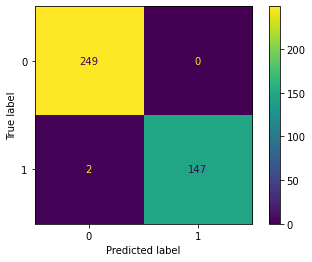

In [26]:
# Confusion matrix for training set

from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_train, y_train)  
plt.show()  

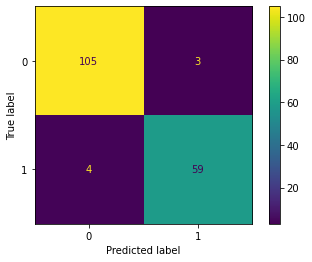

In [27]:
# Confusion matrix for test set

plot_confusion_matrix(clf, X_test, y_test)  
plt.show()  

In [28]:
# Generate the prediction values using predict_proba() function 
pred_proba_clf = clf.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, pred_proba_clf)

# Store the Area Under the Curve (AUC) 
roc_auc = metrics.auc(fpr, tpr)

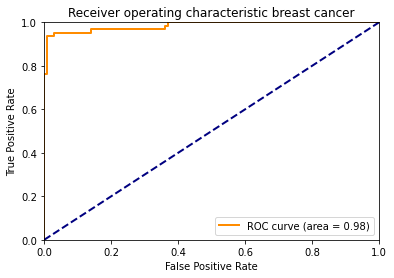

In [30]:
# Plot Roc Auc curve for the training set

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic breast cancer')
plt.legend(loc = "lower right")
plt.show()



---



---



> > > > > > > > > © 2021 Institute of Data


---



---



